In [1]:
!pip install shortuuid

In [2]:
import sys
import os
import math
import base64
import boto3
import sagemaker
import matplotlib.pyplot as plt
import numpy as np
import collections
from collections import defaultdict
from PIL import Image
import sklearn
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from time import time

To avoid altering the conda environment of this notebook and introducing versioning conflicts, we do not pip -r the bioims cli requirements.txt file, although this would would be preferable than using pip directly here. 

In [3]:
s3c = boto3.client('s3')

In [4]:
%pwd

'/root/bioimage-search/datasets/bbbc-021/notebooks'

Change this bucket to the 'data' bucket for your bioimage search project

In [5]:
bioimsArtifactBucket='bioims-data-1'

In [6]:
# assumes cwd=/root/bioimage-search/datasets/bbbc-021/notebooks
sys.path.insert(0, "../../../cli/bioims/src")
import bioims as bi

In [11]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

## Prerequisites

### Permissions
This notebook requires adding the "BioimageSearch" managed policy to the SageMaker execution role. Do this by using the IAM console to add this managed policy to the role for this studio notebook. If the role for studio was auto-created it will begin with "AmazonSageMaker-ExecutionRole". The bioimage search managed policy arn will be something like: arn:aws:iam::580829821648:policy/BioimageSearchResourcePermissionsStack-biomageSearchManagedPolicy9CB9C1D7-SXEV4WNUCZ7V.

### TrainID
This notebook does a baseline, or sanity-check, on the training of the bbbc-021 dataset with a particular model, the context for which is specified by a BioimageSearch 'trainId', an output of the training process. If the evaluation of the results looks reasonable, then the comprehensive 'mechanism of action' (MOA) training series can be run, which creates a separate model for each chemical compound with known MOA. This collection of models, in turn, can be evaluated to determine the likelihood of whether a treatment (i.e., the application of a particular compound at a particular concentration) of unknown MOA would be properly classified. If so, then the model is likely to be useful for assigning MOA to treatments with unknown mechanisms of action, and more broadly for representing a molecule in 'MOA space'.

In [12]:
trainId = 'gEWDUe21eyQ19FmoBmbp3g'

### Steps
* Get the Embedding for the TrainId
* Get the dimensions for the Embedding
* Get the list of compatible plates
* For each plate:
 * Get the origin row of each image to get its metadata
 * Get the embeddings for the specified TrainId
* Combine the metadata and embeddings into a tablular object
* Visualize separability
 * Compute the average embedding for each well
 * Label each well by known MOA (for cases where MOA is known)
 * Use a projection method (e.g., t-sne) to view the separability of results
* Create 'baseline' confusion matrix (not valid due to circular model inclusion, but just for sanity check)
 * For each treatment with known MOA:
   * Compute average across corresponding wells
   * Find the MOA of its nearest neighbor
 * Plot matrix

In [13]:
trainClient = bi.client('training-configuration')

In [14]:
trainInfo = trainClient.getTraining(trainId)

In [15]:
trainInfo

{'filterBucket': '',
 'sagemakerJobName': 'bioims-gEWDUe21eyQ19FmoBmbp3g-M9QbcUauV2Vq8JqEqkj4Wj',
 'messageId': 'd0ede570-1cbc-4bea-8b87-e93fdaa98d2a',
 'filterKey': '',
 'trainId': 'gEWDUe21eyQ19FmoBmbp3g',
 'embeddingName': 'bbbc021-1',
 'executeProcessPlate': 'false'}

In [16]:
embeddingInfo = trainClient.getEmbeddingInfo(trainInfo['embeddingName'])

In [17]:
embeddingInfo

{'roiDepth': 1,
 'trainingHyperparameters': {'backend': 'gloo',
  'batch_size': 1,
  'seed': 1,
  'epochs': 2},
 'roiHeight': 128,
 'trainId': 'origin',
 'inputHeight': 1024,
 'inputWidth': 1280,
 'comments': '',
 'inputChannels': 3,
 'imageMethodArn': 'arn:aws:batch:us-east-1:147147579088:job-definition/imagepreprocessingjobde-91a668a4c3c759e:1',
 'embeddingVectorLength': 256,
 'trainingInstanceType': 'ml.c5.9xlarge',
 'plateMethodArn': 'arn:aws:batch:us-east-1:147147579088:job-definition/platepreprocessingjobde-1af70a04077a5e6:1',
 'inputDepth': 1,
 'modelTrainingScriptBucket': 'bioims-resource-1',
 'wellMethodArn': 'wellMethodArn-placeholder',
 'imagePostMethodArn': 'imagePostMethodArn-placeholder',
 'embeddingName': 'bbbc021-1',
 'modelTrainingScriptKey': 'bbbc021-1-train-script.py',
 'roiWidth': 128}

In [18]:
imageClient = bi.client('image-management')

In [19]:
plates = imageClient.listCompatiblePlates(embeddingInfo['inputWidth'], embeddingInfo['inputHeight'], embeddingInfo['inputDepth'], embeddingInfo['inputChannels'])

In [20]:
plates

[{'plateId': 'eujggQ2vKeEnKAUyUDG9VM'},
 {'plateId': 'c96DPyghVtbaGzBSXFWnc2'},
 {'plateId': 'sGTaDiKsCMYCeo2nPUbnHY'},
 {'plateId': 'qED1YrcCY8WezfD5SS5T74'},
 {'plateId': 'oyWFh65mfwFXto6ZpEgRGF'},
 {'plateId': 'kyz9xdkQjQE7vJZEWV6J56'},
 {'plateId': 'dXond4suxZaiPNQmk1nKAL'},
 {'plateId': 'ghPbDnosRuf3pKX3iB7Y7y'},
 {'plateId': 't6wNRPrJzRf1dVx7pJsoEQ'},
 {'plateId': 'eQfFvwxdwDQUkJ8Jkc1SnD'},
 {'plateId': '1QHfZ7jiEwX2ConLdpJM8q'},
 {'plateId': 'd92HJzFnBsnw4pLgGuodNU'},
 {'plateId': 'gbbdooyyCSL8NZLnUeiGFT'},
 {'plateId': '4NLS3DTAUWqsWmEHVg6c9u'},
 {'plateId': 'b463LYid8uNiyg2gRzN8pT'},
 {'plateId': 'cKSMjvb9xYPjZqaE7MAZRt'},
 {'plateId': 'e1iLb8JdfDZ1cwrgKnZoky'},
 {'plateId': 'kHZCMGjdvJfKDkT5GMoNsU'},
 {'plateId': 'bfcnG3HyDWZP6jCadtJRja'},
 {'plateId': 'xaqj3RmNFxcXh88j3vkD4f'},
 {'plateId': '3D6z13TPyxCvnZYDnyQti9'},
 {'plateId': '2TDyDvaXUDDzZHMPhFFdqb'},
 {'plateId': 'iDUMuYk1srM5cax9GtBkWN'},
 {'plateId': 'iGwLzYaPkCDDT7sLM17j1k'},
 {'plateId': 'cmBqiRXiqzD4LGRTnjJJmh'},


In [26]:
imagePlateExample = imageClient.getImagesByPlateId(plates[0]['plateId'])

In [27]:
imagePlateExample[0]

{'Item': {'trainCategory': 'moa',
  'imageId': '3UfaNrrsTb9s3ArD5RN7EZ',
  'plateId': 'eujggQ2vKeEnKAUyUDG9VM',
  'trainId': 'origin',
  'depth': '1',
  'plateSourceId': 'Week9_39222',
  'bucket': 'bioimagesearchbbbc021stack-bbbc021bucket544c3e64-ugln15rb234b',
  'experiment': 'BBBC021_v1',
  'channelKeys': [{'name': 'dapi',
    'keysuffix': 'Week9_39222/Week9_090907_E08_s3_w11723BBAB-9A30-4A75-B5D8-50DAE00E3E3D.tif'},
   {'name': 'tubulin',
    'keysuffix': 'Week9_39222/Week9_090907_E08_s3_w2BE97D124-4C01-44BD-923A-B41D5AD8B210.tif'},
   {'name': 'actin',
    'keysuffix': 'Week9_39222/Week9_090907_E08_s3_w42CB3D146-A575-4489-9BBE-1FA85A9947FB.tif'}],
  'wellId': 'kvF3uBsLkxJArJQQbWfpEm',
  'imageSourceId': 'Week9_090907_E08_s3_w11723BBAB-9A30-4A75-B5D8-50DAE00E3E3D',
  'messageId': 'b197553a-f60c-48f4-ad1d-2dd2f6ccd680',
  'searchReady': 'VALIDATED',
  'height': '1024',
  'width': '1280',
  'wellSourceId': 'E08',
  'channels': '3',
  'trainLabel': 'Cholesterol-lowering',
  'key': '',


In [28]:
embeddingPlateExample = imageClient.getImagesByPlateIdAndTrainId(plates[0]['plateId'], trainId)

In [29]:
embeddingPlateExample[0]

{'Item': {'imageId': '4mSgDeQobVMF3VdSUVd4Ft',
  'embedding': "b'p3OJvVhUT728b4a9Q4pbPLthJD2ZL0S9nBJqPGNlPr1XtMq8U5pNvGjD1j1CdXm9LgmiOdiAH718//C7AbkRPcXFbD0MpdY82qwOPFJr+rzFyAM9Co4TPcnu+L0EGE69yMA8vOYeMD2Q+zE81WqZvHb8Drx7k3G8elUCPs3lOr3lOS48e5D+vaJc/TzdGY+9Y8qMvZ5nDb2H2Hk9WPHKPPLAlz2et6C9udzuOrAjbD0TXb46LQICvTLU6Dz8Xo69gRzDvaOSurz0LYE9LZNVPYrUl70UeZI8bPYUvPRUzTqPlz09Zx0uvG5fV7tPejI8LMHavE7sZLzOATq9VfKyvJv4SLzHZ5S94JyHvCP/Fj02Si0+BQ/9vIlnV7w7fC89J6pgvAzJCT3DFdE8JMrJO2q3qDxbUDs9hLCivaw0L72cAka9s1iHPUza8rzOZVY93KkYPfdB6zw7lR89szFHPV4/Wb3FObm9YlGRvCA3Gr1LUmI8UdgYvRDeq73k/zK70p2EOip6ML2sb8E8q+qYvaw6WL37TIe8dAuqveJ3FL2LeJU8tE2OPG3SRbzEagK9DlvtPNVWeTyrKsA7+0QHvEYATj2BoFK9Ciw1vcDpQ712jpY9JGJLu67uxLye2QS9qFUUPOxLHjrFc329y36cPeskybwN5LA9mzimvYuimDsv04g8tZPYug8GlTxUHle9spRxOwFKvzuX9G29fFssvYzwOj0Fwpo9h8pkvMcpijybbXC9z9lHvGeJPzzwSGW8PKOZO1ncVrwXjQo8Qlz4u9Ctcj3qQqY9pSGTvFcvDLyuGXS9i/YLvay7H7xvCCw9NWjxvBsxQL0nRD29hDMePcTR1DuVR7W8nD0qvI4i0T38z0a9+kERPRwM0L3wbr275FCTPM1DsjwEWys9AUUePWAbob1e7Qs9G4n+vIf

In [30]:
#e1 = "b'i6qJPbpKHL5IZSK+akeqPRVh570Wlvm869mrvXp6Pj5qKMy918wAvnCsQr6zHe+91nTsvalCALx3twG+Et21PRMvhb1Qzkw8mda2PYVZtD2RXyu7ggIWPs4AnT2keSE9oQ8ePqkEvL0bN4K97uzDPQ1NuD22JbO8TTCPvHkVCr0='"
e1 = embeddingPlateExample[0]['Item']['embedding']

In [31]:
e2 = e1.split("\'")

In [32]:
e3=e2[1].encode()

In [33]:
e4 = base64.decodebytes(e3)
e5 = np.frombuffer(e4, dtype=np.float32)

In [34]:
e5

array([-0.06711512, -0.05061755, -0.0656428 ,  0.01339966,  0.04013227,
       -0.04789696,  0.01428666, -0.04648341, -0.0247442 , -0.012549  ,
        0.1048649 , -0.06090284,  0.00030906, -0.03894123, -0.00735467,
        0.03557682,  0.0578058 ,  0.02620175,  0.0087082 , -0.03056875,
        0.03217389,  0.03602413, -0.1215492 , -0.05031587, -0.01152057,
        0.04299822,  0.0108632 , -0.0187277 , -0.00872718, -0.01474463,
        0.12727919, -0.04562931,  0.01063392, -0.12429901,  0.03092796,
       -0.06987355, -0.0687454 , -0.03452265,  0.06099751,  0.02477328,
        0.07409848, -0.07847522,  0.00182237,  0.05765122,  0.00145236,
       -0.03174036,  0.0284215 , -0.06951711, -0.09526921, -0.022775  ,
        0.06307593,  0.05214231, -0.07413585,  0.01788   , -0.00909195,
        0.00156656,  0.04628712, -0.01062713, -0.00328633,  0.01089342,
       -0.02670344, -0.01397236, -0.04541188, -0.02184407, -0.0122663 ,
       -0.07246356, -0.0165543 ,  0.03686441,  0.1692284 , -0.03

In [35]:
embeddingWidth=len(e5)

In [36]:
embeddingWidth

256

In [37]:
plateMap={}

In [38]:
for plateEntry in plates:
    plateId=plateEntry['plateId']
    print("Adding plateId {}".format(plateId))
    images=imageClient.getImagesByPlateId(plateId)
    embeddings=imageClient.getImagesByPlateIdAndTrainId(plateId, trainId)
    imageMap={}
    for imageItem in images:
        image=imageItem['Item']
        imageId=image['imageId']
        imageMap[imageId]=image
    print("  found {} image entries".format(len(imageMap)))
    embeddingMap={}
    for embeddingItem in embeddings:
        if 'Item' in embeddingItem:
            embedding=embeddingItem['Item']
            imageId=embedding['imageId']
            e1=embedding['embedding']
            e2=e1.split("\'")
            e3=e2[1].encode()
            e4=base64.decodebytes(e3)
            e5=np.frombuffer(e4, dtype=np.float32)
            embedding['np']=e5
            embeddingMap[imageId]=embedding
    print("  found {} embedding entries".format(len(embeddingMap)))
    plateInfo = {
        "images" : imageMap,
        "embeddings" : embeddingMap
    }
    plateMap[plateId]=plateInfo

Adding plateId eujggQ2vKeEnKAUyUDG9VM
  found 240 image entries
  found 235 embedding entries
Adding plateId c96DPyghVtbaGzBSXFWnc2
  found 240 image entries
  found 240 embedding entries
Adding plateId sGTaDiKsCMYCeo2nPUbnHY
  found 240 image entries
  found 204 embedding entries
Adding plateId qED1YrcCY8WezfD5SS5T74
  found 240 image entries
  found 230 embedding entries
Adding plateId oyWFh65mfwFXto6ZpEgRGF
  found 240 image entries
  found 240 embedding entries
Adding plateId kyz9xdkQjQE7vJZEWV6J56
  found 240 image entries
  found 240 embedding entries
Adding plateId dXond4suxZaiPNQmk1nKAL
  found 240 image entries
  found 240 embedding entries
Adding plateId ghPbDnosRuf3pKX3iB7Y7y
  found 240 image entries
  found 240 embedding entries
Adding plateId t6wNRPrJzRf1dVx7pJsoEQ
  found 240 image entries
  found 240 embedding entries
Adding plateId eQfFvwxdwDQUkJ8Jkc1SnD
  found 240 image entries
  found 234 embedding entries
Adding plateId 1QHfZ7jiEwX2ConLdpJM8q
  found 240 image entr

# Review Plate Images

Here I'd like to select a plate and visualize all composite images.

In [39]:
artifactClient=bi.client('artifact')

In [41]:
imageId0 = embeddingPlateExample[0]['Item']['imageId']

In [42]:
artifactClient.getArtifacts(imageId0, 'origin')

[{'contextId': '4mSgDeQobVMF3VdSUVd4Ft#origin',
  'annotation': [],
  'description': '',
  'artifact': 's3key#artifact/plate/eujggQ2vKeEnKAUyUDG9VM/default/image/4mSgDeQobVMF3VdSUVd4Ft/medium-2d.png',
  'createTimestamp': '1616774154497'},
 {'contextId': '4mSgDeQobVMF3VdSUVd4Ft#origin',
  'annotation': [],
  'description': '',
  'artifact': 's3key#artifact/plate/eujggQ2vKeEnKAUyUDG9VM/default/image/4mSgDeQobVMF3VdSUVd4Ft/thumbnail-2d.png',
  'createTimestamp': '1616774153745'}]

In [43]:
plateId = imagePlateExample[0]['Item']['plateId']

In [44]:
def showImage(im):
    #plt.figure(figsize=(20,15))
    plt.figure(figsize=(4,15))
    plt.subplot(1,1,1)
    plt.xticks([])
    plt.yticks([])
    print("shape=", im.size)
    print("format=", im.format)
    ip=plt.imshow(im)
    #plt.xlabel(0)
    plt.show()

In [45]:
def displayImages(images, columns, fx, fy):
    plt.figure(figsize=(fx,fy))
    l =len(images)
    spx=columns
    spy=math.ceil(l/spx)
    i=0
    for imkey in images:
        fo = s3c.get_object(Bucket=bioimsArtifactBucket, Key=imkey)
        fs = fo['Body']
        im = Image.open(fs)
        plt.subplot(spy,spx,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(im)
        plt.xlabel(i)
        i+=1

In [46]:
def displayThumbnailsForPlate(plateId):
    plateDataMap = plateMap[plateId]
    imageMap = plateDataMap['images']
    imageIds = imageMap.keys()
    keyList = []
    for imageId in imageIds:
        artifactList = artifactClient.getArtifacts(imageId, 'origin')
        for artifact in artifactList:
            s3key = artifact['artifact']
        if s3key.endswith('thumbnail-2d.png'):
            components = s3key.split('#')
            keyList.append(components[1])
    displayImages(keyList, 10, 20, 40)

This step could take 1-2 minutes to render

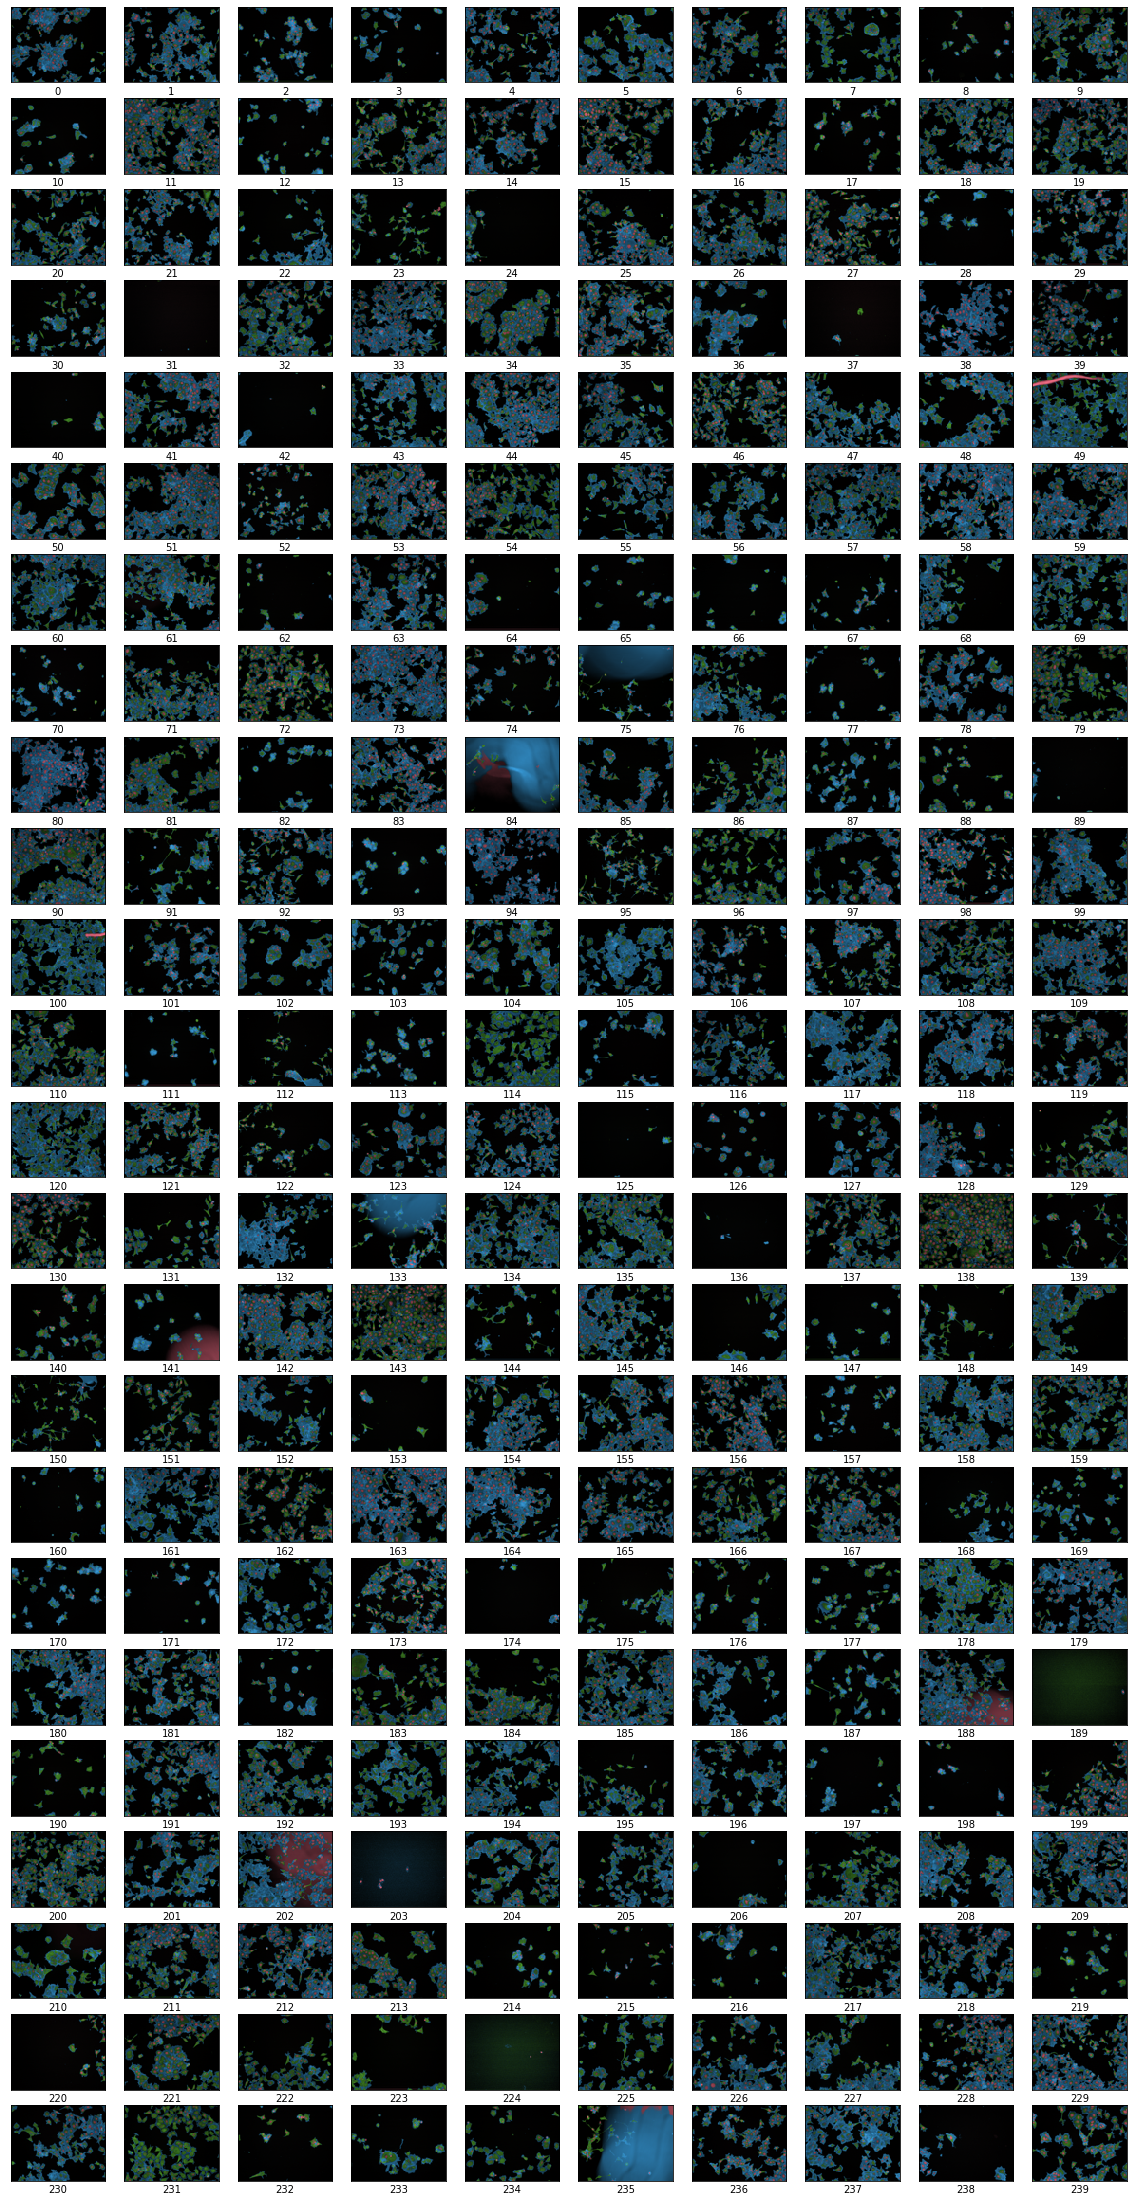

In [48]:
displayThumbnailsForPlate(plateId)

Next, we create a mapping from MOA->well-embedding, where we will naively take the average of the embeddings for each well (there are several images per well). An alternative would be taking the median.

In [49]:
wellMap = {}

In [50]:
imageCount=0
for plateId in plateMap:
    print("plate {}".format(plateId))
    plateInfo = plateMap[plateId]
    imageMap = plateInfo['images']
    embeddingMap = plateInfo['embeddings']
    for imageId in imageMap:
        imageInfo = imageMap[imageId]
        if imageId in embeddingMap:
            embeddingInfo = embeddingMap[imageId]
            if 'trainLabel' in imageInfo and 'np' in embeddingInfo:
                wellId = imageInfo['wellId']
                if wellId not in wellMap:
                    imageArr = []
                    wellMap[wellId]=imageArr
                imageArr = wellMap[wellId]
                imageEntry = {}
                imageEntry['label']=imageInfo['trainLabel']
                imageEntry['np']=embeddingInfo['np']
                imageArr.append(imageEntry)
                imageCount+=1
print("Found {} wells".format(len(wellMap)))
print("Found {} images with MOA labels and embeddings".format(imageCount))

plate eujggQ2vKeEnKAUyUDG9VM
plate c96DPyghVtbaGzBSXFWnc2
plate sGTaDiKsCMYCeo2nPUbnHY
plate qED1YrcCY8WezfD5SS5T74
plate oyWFh65mfwFXto6ZpEgRGF
plate kyz9xdkQjQE7vJZEWV6J56
plate dXond4suxZaiPNQmk1nKAL
plate ghPbDnosRuf3pKX3iB7Y7y
plate t6wNRPrJzRf1dVx7pJsoEQ
plate eQfFvwxdwDQUkJ8Jkc1SnD
plate 1QHfZ7jiEwX2ConLdpJM8q
plate d92HJzFnBsnw4pLgGuodNU
plate gbbdooyyCSL8NZLnUeiGFT
plate 4NLS3DTAUWqsWmEHVg6c9u
plate b463LYid8uNiyg2gRzN8pT
plate cKSMjvb9xYPjZqaE7MAZRt
plate e1iLb8JdfDZ1cwrgKnZoky
plate kHZCMGjdvJfKDkT5GMoNsU
plate bfcnG3HyDWZP6jCadtJRja
plate xaqj3RmNFxcXh88j3vkD4f
plate 3D6z13TPyxCvnZYDnyQti9
plate 2TDyDvaXUDDzZHMPhFFdqb
plate iDUMuYk1srM5cax9GtBkWN
plate iGwLzYaPkCDDT7sLM17j1k
plate cmBqiRXiqzD4LGRTnjJJmh
plate 9YzJAUmuwDPMxrFhqYnJn8
plate mzJp7dN9vUcjBunxaXvRkK
plate 6RMdv31WdkDpwrnZVpRbHA
plate rv3m6X4vYNRUStvymXxppv
plate kQMYnpLGepokAtqCWTx6Lw
plate d985istuyM9Ann8Ag9MNPW
plate dGonD3SiGAmKJmZbCw7xXd
plate 9rSMUPPuixFfUXQ2nwqKdt
plate 4ESGtiwTfzPSQkHDw47Ppt
plate s7YdHAgt

In [51]:
moaMap={}

In [52]:
for wellId in wellMap:
    imageArr = wellMap[wellId]
    label = imageArr[0]['label']
    if label not in moaMap:
        wellArr = []
        moaMap[label]=wellArr
    wellArr = moaMap[label]
    embeddingArr = []
    for imageEntry in imageArr:
        npe = imageEntry['np']
        embeddingArr.append(npe)
    npa = np.asarray(embeddingArr)
    npm = np.mean(npa, axis=0)
    wellArr.append(npm)

In [53]:
embeddingCount=0
for label in moaMap:
    wellArr = moaMap[label]
    print("label {} has {} entries".format(label, len(wellArr)))
    embeddingCount += len(wellArr)

label Cholesterol-lowering has 48 entries
label Microtubule stabilizers has 402 entries
label DMSO has 330 entries
label Protein degradation has 94 entries
label DNA replication has 96 entries
label Microtubule destabilizers has 96 entries
label Actin disruptors has 72 entries
label Aurora kinase inhibitors has 72 entries
label DNA damage has 96 entries
label Protein synthesis has 72 entries
label Eg5 inhibitors has 45 entries
label Epithelial has 64 entries
label Kinase inhibitors has 48 entries


The embedding count below should match the number of wells

In [57]:
embeddingCount

1535

In [58]:
moaSortedArr = []
moaLabelMap = {}
for label in moaMap:
    moaSortedArr.append(label)

In [59]:
moaSortedArr

['Cholesterol-lowering',
 'Microtubule stabilizers',
 'DMSO',
 'Protein degradation',
 'DNA replication',
 'Microtubule destabilizers',
 'Actin disruptors',
 'Aurora kinase inhibitors',
 'DNA damage',
 'Protein synthesis',
 'Eg5 inhibitors',
 'Epithelial',
 'Kinase inhibitors']

In [60]:
moaSortedArr.sort()

In [61]:
moaSortedArr

['Actin disruptors',
 'Aurora kinase inhibitors',
 'Cholesterol-lowering',
 'DMSO',
 'DNA damage',
 'DNA replication',
 'Eg5 inhibitors',
 'Epithelial',
 'Kinase inhibitors',
 'Microtubule destabilizers',
 'Microtubule stabilizers',
 'Protein degradation',
 'Protein synthesis']

In [62]:
for i, l in enumerate(moaSortedArr):
    moaLabelMap[l] = i

In [63]:
orderedEmbedding = np.empty( (embeddingCount, embeddingWidth), dtype=np.float32 )

In [64]:
orderedLabels = np.empty(embeddingCount, dtype=np.int32)

In [65]:
i=0
for label in moaMap:
    wellArr = moaMap[label]
    for embedding in wellArr:
        orderedEmbedding[i]=embedding
        orderedLabels[i]=moaLabelMap[label]
        i += 1

In [66]:
near_neighbors_per_example = 10
gram_matrix = np.einsum("ae,be->ab", orderedEmbedding, orderedEmbedding)
near_neighbors = np.argsort(gram_matrix.T)[:, -(near_neighbors_per_example + 1) :]

In [67]:
class_idx_to_train_idxs = defaultdict(list)
for y_train_idx, y in enumerate(orderedLabels):
    class_idx_to_train_idxs[y].append(y_train_idx)

In [68]:
num_classes = 13
confusion_matrix = np.zeros((num_classes, num_classes))

# For each class.
for class_idx in range(num_classes):
    example_idxs = class_idx_to_train_idxs[class_idx][:near_neighbors_per_example]
    for y_test_idx in example_idxs:
        # Count the classes of its near neighbours.
        for nn_idx in near_neighbors[y_test_idx][:-1]:
            nn_class_idx = orderedLabels[nn_idx]
            confusion_matrix[class_idx, nn_class_idx] += 1

NOTE: with Confusion Matrix below, category 'DMSO' (predicted label 3), is equivalent to 'no treatment' since DMSO is the chemical control buffer. Therefore, we should not be surprised to see off-diagonals that represent a kind of 'best guess' network outcome. 

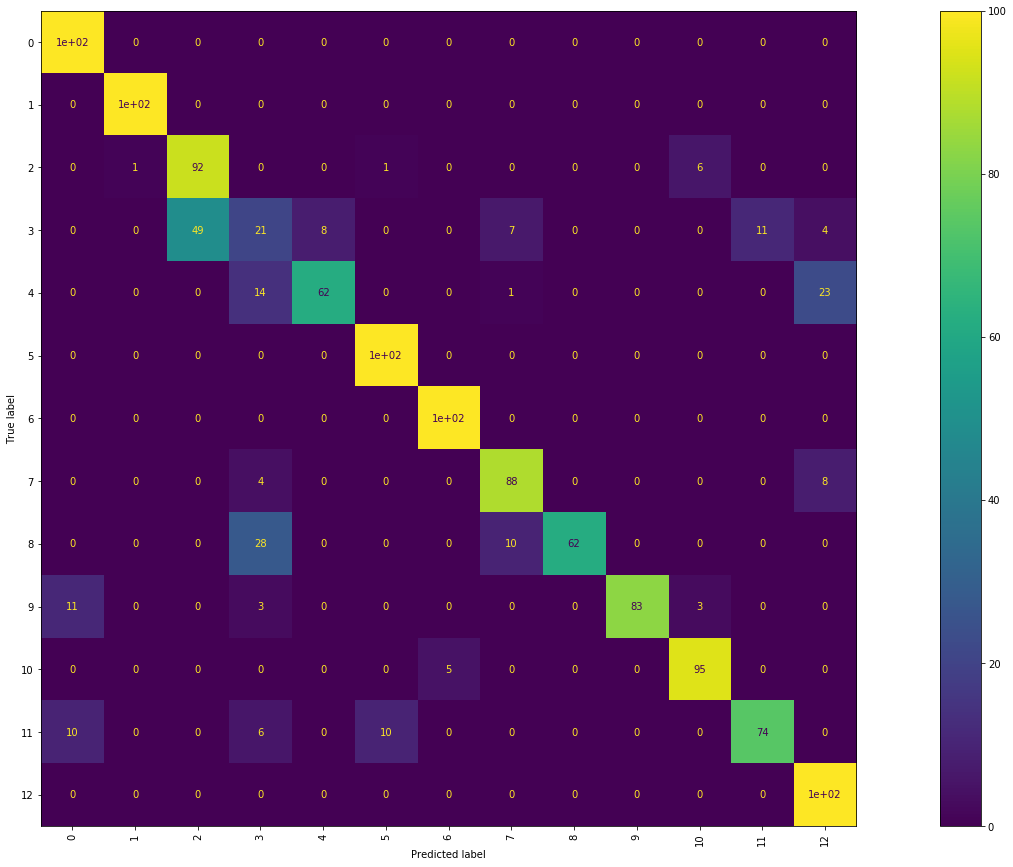

In [69]:
# Display a confusion matrix.
labels = [
    "0",
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9",
    "10",
    "11",
    "12"
]
plt.rcParams["figure.figsize"] = (30,15)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)
disp.plot(include_values=True, cmap="viridis", ax=None, xticks_rotation="vertical")
plt.show()

In [70]:
moaLabelMap

{'Actin disruptors': 0,
 'Aurora kinase inhibitors': 1,
 'Cholesterol-lowering': 2,
 'DMSO': 3,
 'DNA damage': 4,
 'DNA replication': 5,
 'Eg5 inhibitors': 6,
 'Epithelial': 7,
 'Kinase inhibitors': 8,
 'Microtubule destabilizers': 9,
 'Microtubule stabilizers': 10,
 'Protein degradation': 11,
 'Protein synthesis': 12}

In [71]:
colorList=['b', '#55ff55', 'r', 'c', 'm', 'y', 'k', '#eeeeee', '#777777', '#ff9999', '#880000', '#009900', '#000088']

NOTE: we remove DMSO from the t-sne plot since it is the 'no treatment' control

In [72]:
embeddingClassMembership=[]
for c in range(num_classes):
    if c == 3:
        r1 = orderedLabels == -1
    else:
        r1 = orderedLabels == c
    r2 = collections.Counter(r1)
    embeddingClassMembership.append(r1)

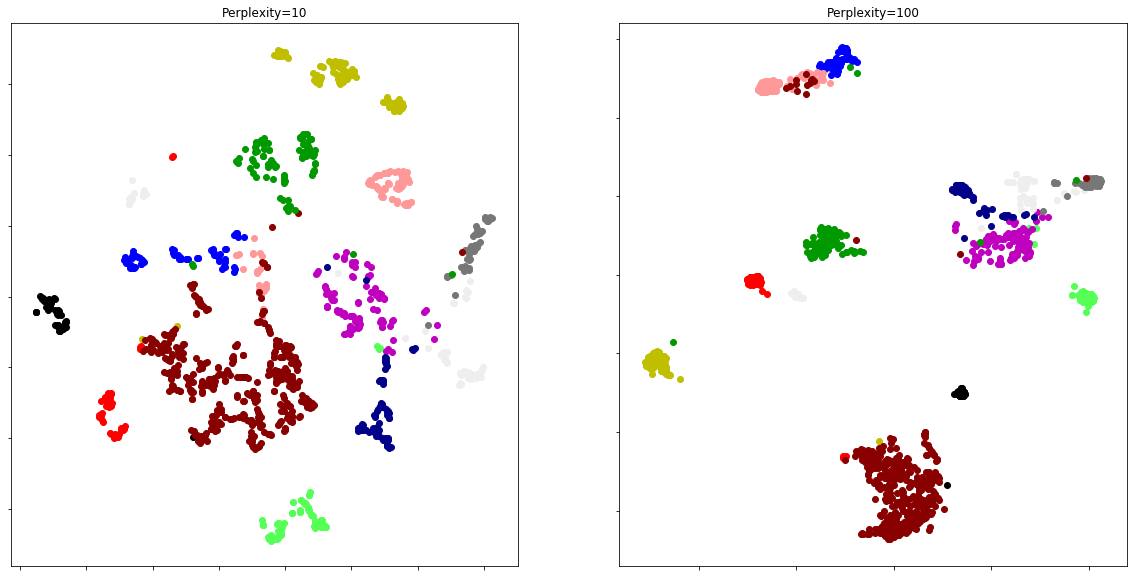

In [73]:
(fig2, subplots2) = plt.subplots(1, 2, figsize=(20, 10))
perplexities = [10, 100]

for i, perplexity in enumerate(perplexities):
    ax = subplots2[i]
    tsne = manifold.TSNE(n_components=2, init='random', random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(orderedEmbedding)
    ax.set_title("Perplexity=%d" % perplexity)
    for cl in range(num_classes):
        if cl != 3:
            ax.scatter(Y[embeddingClassMembership[cl], 0], Y[embeddingClassMembership[cl], 1], c=colorList[cl])
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')